In [ ]:
# Used this version of get_plasmid_inserts.py:
# !pip install git+https://github.com/nmateyko/labutils.git@5591e4ffd4a80c80687e5fe42b46392bd557d7e1

In [53]:
import Levenshtein
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.Align import PairwiseAligner
from collections import Counter
from sequence_analysis.utils import read_fastq, revcomp
from sequence_analysis.get_plasmid_inserts import get_insert, first_index_of_kmer
from tqdm import tqdm

Get plasmid reads from fastq

In [2]:
with open('Lab_w7p_1_MORF_Stable.fastq', 'r') as f:
    fastq_reader = read_fastq(f)
    reads = [read for read in fastq_reader]
print(f"{len(reads)} reads.")

1902 reads.


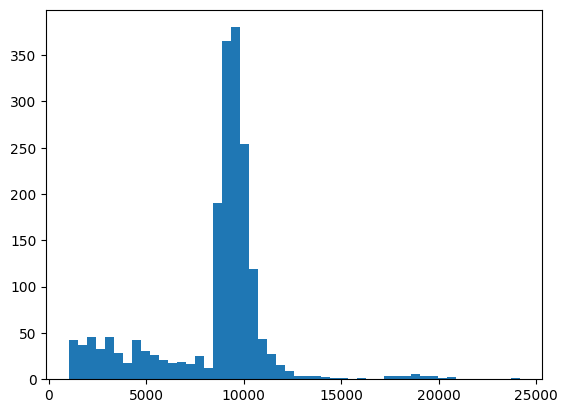

In [3]:
plt.hist([len(read[1]) for read in reads], bins=50)
plt.show()

See how many reads align properly to the expected vector sequence (https://benchling.com/s/seq-bPXmkxUwNKpX1cH3L3Ot?m=slm-LDQriBDlF3302DPZLMDe). Reindex the reads starting at the ampicillin resistance gene, as all plasmids should have this.

In [4]:
QUERY = 'ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATG'

In [9]:
# concatenate each sequence to itself in case the read starts in the middle of the insert site
reads_concat = [(header, seq + seq, qual + qual) for header, seq, qual in reads]

# get first instance of upstream sequence and the sequence downstream of it
reindexed_reads = []
failed = []
for header, seq, qual in reads_concat:
    index = first_index_of_kmer(seq, QUERY, 10, Levenshtein.distance)
    if index >= 0:
        reindexed_seq = seq[index:index + int(len(seq)/2)]
        reindexed_qual = qual[index:index + int(len(seq)/2)]
        reindexed_reads.append((header, reindexed_seq, reindexed_qual))
    else:
        index_rev = first_index_of_kmer(revcomp(seq), QUERY, 15, Levenshtein.distance)
        if index_rev >= 0:
            reindexed_seq = revcomp(seq)[index_rev:index_rev + int(len(seq)/2)]
            reindexed_qual = qual[::-1][index_rev:index_rev + int(len(seq)/2)]
            reindexed_reads.append((header, reindexed_seq, reindexed_qual))
        else:
            failed.append((header, seq, qual))

In [10]:
print(f"{len(reindexed_reads)} reads match AmpR out of {len(reads)} total reads.")

1572 reads match AmpR out of 1902 total reads.


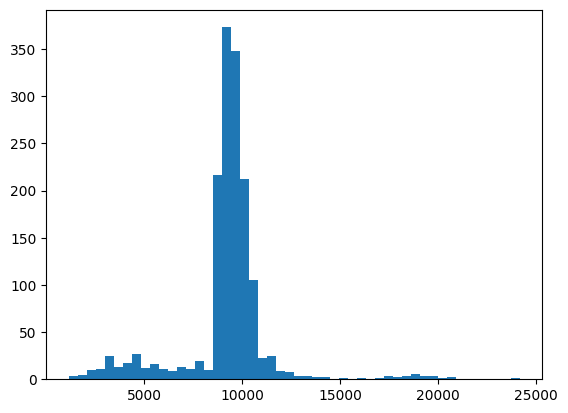

In [11]:
plt.hist([len(read[1]) for read in reindexed_reads], bins=50)
plt.show()

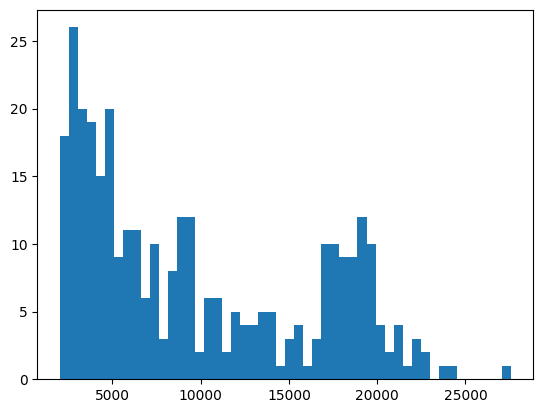

In [12]:
plt.hist([len(read[1]) for read in failed], bins=50)
plt.show()

Read in expected vector sequence and align reindexed reads to it.

In [13]:
with open("MORF_nogene_ampR_start.txt", 'rt') as f:
    plasmid = f.readline()
plasmid = plasmid.upper()
print(len(plasmid))

8365


In [17]:
def encode_alignment(ref, query):
    encoded = []
    for i, j in zip(ref, query):
        if i == j:
            encoded.append(0)
        elif i != j and '-' not in {i, j}:
            encoded.append(1)
        elif i == '-' and j != '-':
            encoded.append(2)
        elif i != '-' and j == '-':
            encoded.append(3)
        else:
            raise ValueError("I wasn't expecting this")
    return encoded

def pad_lengths(d):
    max_len = max([len(v) for v in d.values()])
    for k, v in d.items():
        d[k] = v + [-1] * (max_len - len(v))
# d = {'a': [1, 2, 3], 'b': [1, 2]}
# pad_lengths(d)
# d

Only do alignment for a subset because it takes a long time.

In [ ]:
aligner = PairwiseAligner(mode='global', match_score=2, mismatch_score=-1,
                          open_gap_score=-5, extend_gap_score=0)

In [19]:
encoded_alignments = dict()
for read in reindexed_reads[:200]:
    alignments = aligner.align(plasmid, read[1])
    alignment = next(alignments)
    encoded = encode_alignment(alignment[0], alignment[1])
    encoded_alignments[read[0]] = encoded

In [20]:
pad_lengths(encoded_alignments)
alignments_df = pd.DataFrame.from_dict(encoded_alignments, orient='index')

AmpR starts at 0. E. coli ori ends at 1620. Gene begins at 6200.

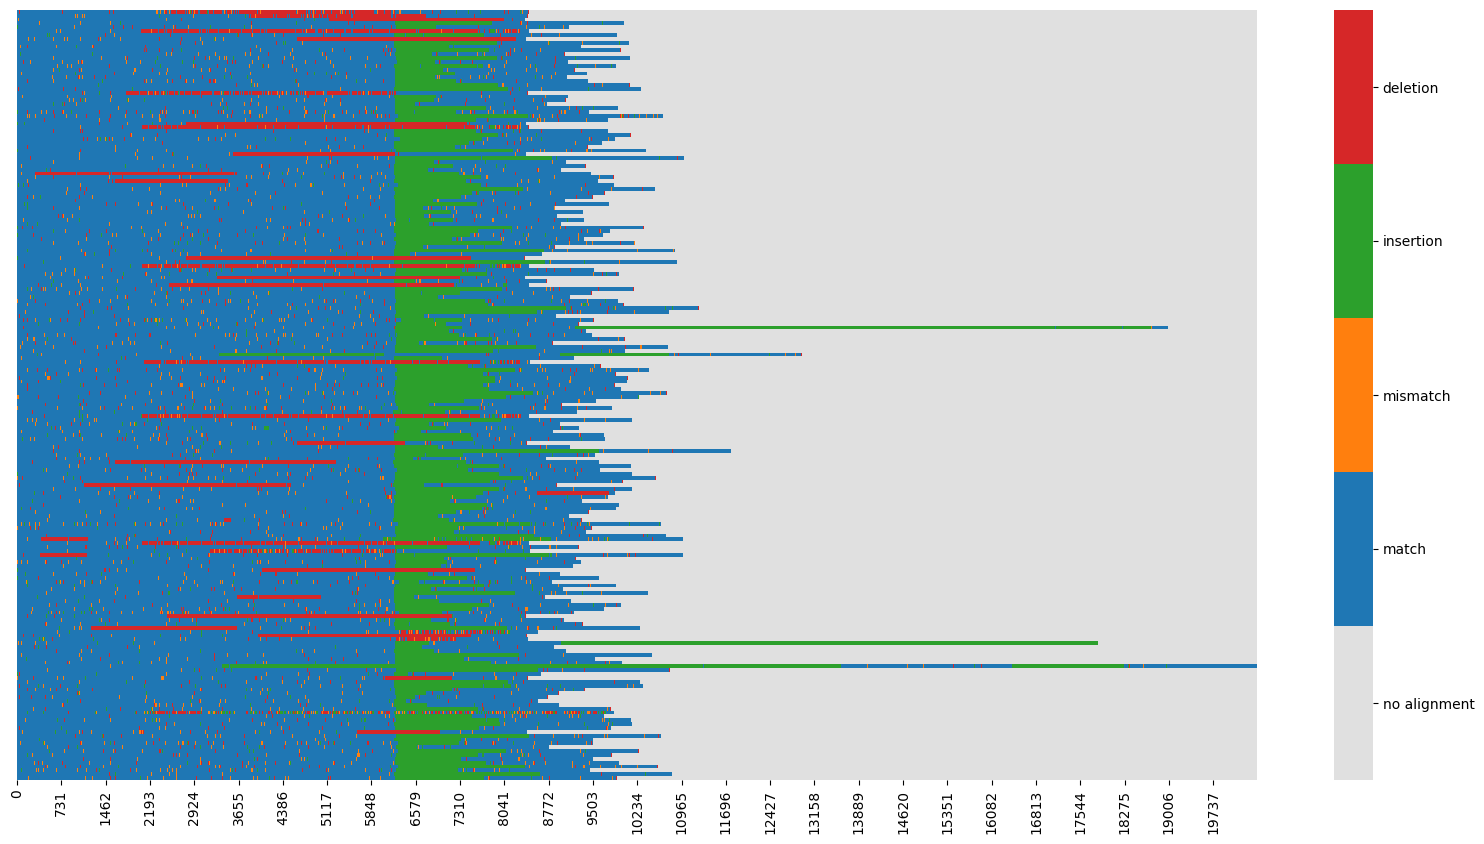

In [21]:
cmap = sns.color_palette(['#e0e0e0', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax = sns.heatmap(alignments_df, cmap=cmap)
plt.yticks([])
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
colorbar.set_ticklabels(['no alignment', 'match', 'mismatch', 'insertion', 'deletion'])
plt.gcf().set_size_inches(20, 10)
plt.show()

The reads with a large section of deletion starting around 1500 bp are probably recombined plasmids. There are ~23 of these, so around 10% of the library is recombined plasmids. A few appear to have deletions in the AmpR region, which I imagine are nanopore sequencing artifacts. A few reads are very long; these are probably plasmid dimers. The rest of the plasmids appear to be okay; they all have a green addition region where the TF gene should be.

Define flanking regions (from pLX_TRC317; https://benchling.com/s/seq-3ND5VgqxGXSY3C0ScBOo?m=slm-ju7NQXGR4gPMzqh53eZx)

In [22]:
BC_UP = 'TTGGCTTTATATATCTTGTGGAAAGGACGA'
BC_DOWN = 'ACGCGTTAAGTCGACAATCAACCTCTGGAT'
GENE_UP = 'GTTTTTTTCTTCCATTTCAGGTGTCGTGAG'
GENE_DOWN = 'GTCGACAATCAACCTCTGGATTACAAAATT'
GENE_UP_2 = 'GAGTTTGGATCTTGGTTCATTCTCAAGCCT'
GENE_DOWN_2 = 'TAGTAATGAACTAGTCCGTAACTTGAAAGT'

Extract barcode and gene from each plasmid read.

In [24]:
extracted = []
for read in reads:
    barcode = get_insert(read, up=BC_UP, down=BC_DOWN, length=24, t=10, dist_func=Levenshtein.distance)
    gene = get_insert(read, up=GENE_UP, down=GENE_DOWN, length=10000, t=10, dist_func=Levenshtein.distance)
    if barcode and gene:
        extracted.append((barcode[1][0], gene[1][0]))
        # extracted.append(gene[1][0])
print(f"{len(extracted)} barcode-gene pairs out of {len(reads)} total reads.")

1354 barcode-gene pairs out of 1902 total reads .


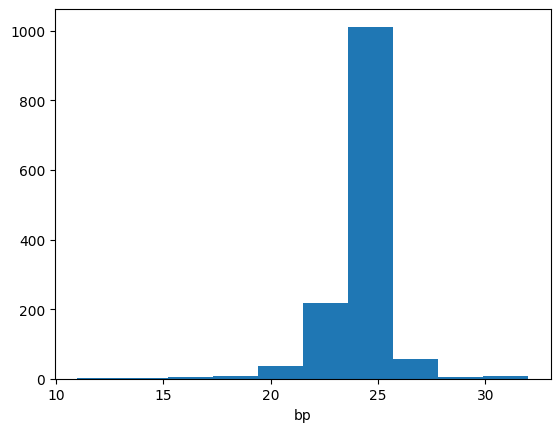

In [28]:
plt.hist([len(bc) for bc, gene in extracted])
plt.xlabel("bp")
plt.show()

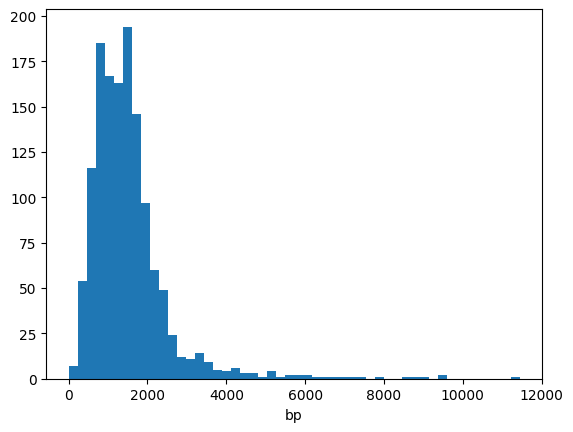

In [29]:
plt.hist([len(gene) for bc, gene in extracted], bins=50)
plt.xlabel("bp")
plt.show()

Read in MORF barcode-gene pairings.

In [27]:
bc_gene_pairs = pd.read_csv('200102_tf_orf_library.csv')
bc_gene_pairs.head()

,Name,RefSeq Gene Name,RefSeq and Gencode ID,Barcode Sequence,ORF sequence,Full sequence,Notes 1,Notes 2
0,TFORF0001,HIF3A,"NM_022462,ENST00000244303",AGTCAAGACCCTCGGGCTCTGTGG,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
1,TFORF0002,HIF3A,"NM_152796,ENST00000472815",CAATTACACCACGTCTGCCTACTA,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
2,TFORF0003,HIF3A,"NM_152794,ENST00000300862",TTCAGACGTTTCGCGCCTGGAGCT,ATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGCGCAAGGAAA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
3,TFORF0004,HIF3A,"XM_005259153,ENST00000600383",GATAACGCTAACCACAAGGTATTT,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
4,TFORF0005,HIF3A,"NM_152795,ENST00000377670",CCACGCGAGCTAGACGATCGATGA,ATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGGAGCTGCGCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN


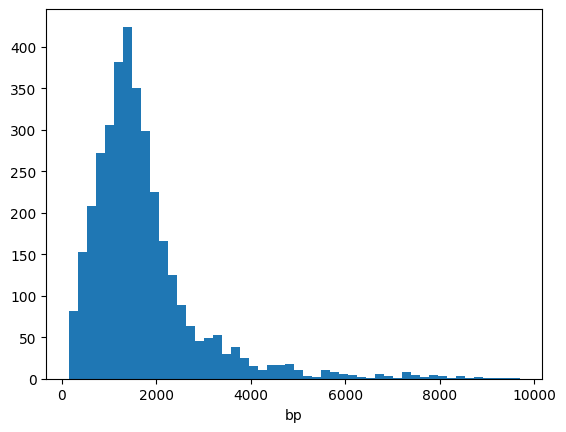

In [31]:
plt.hist([len(seq) for seq in bc_gene_pairs['ORF sequence']], bins=50)
plt.xlabel('bp')
plt.show()

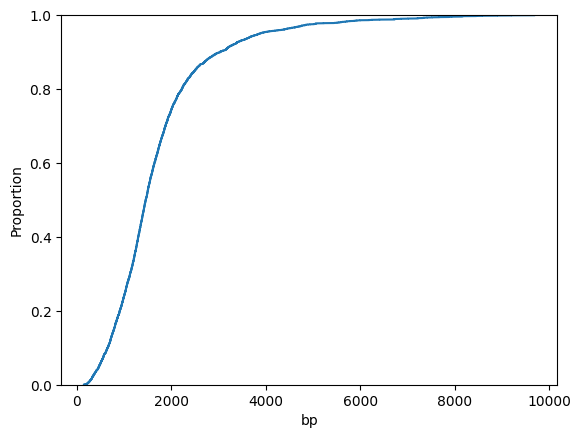

In [32]:
sns.ecdfplot([len(seq) for seq in bc_gene_pairs['ORF sequence']])
plt.xlabel('bp')
plt.show()

Find the minimum distance between barcodes.

In [33]:
min_dists = []
ref_barcodes = list(bc_gene_pairs['Barcode Sequence'])
for i, bc_1 in enumerate(ref_barcodes):
    min_dist = 100
    for j, bc_2 in enumerate(ref_barcodes):
        if i != j:
            dist = Levenshtein.distance(bc_1, bc_2)
            if dist < min_dist:
                min_dist = dist
    min_dists.append(min_dist)

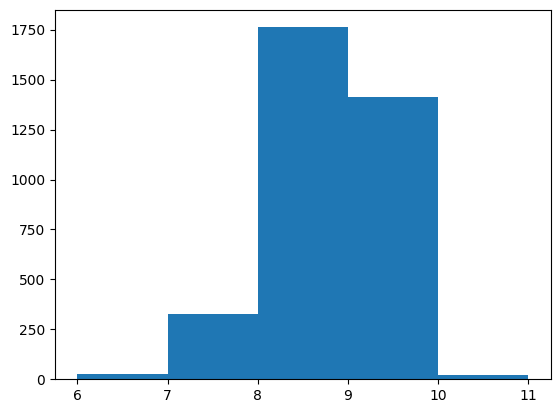

In [34]:
plt.hist(min_dists, bins=range(min(min_dists), max(min_dists) + 2))
plt.show()

A distance threshold of 6 for matching barcodes should be good; even though a few barcodes are this distance apart, the chance that one of the reads got the exact set of mutations that would transform one barcode into another is very unlikely.

Search for barcode match between extracted barcodes and reference barcodes. Tried with a distance of 6 and some extracted barcodes had more than 1 match, so reduced to a distance of 5.

In [43]:
bc_counts = {bc: 0 for bc in ref_barcodes}
bc_matches = []
for read_bc, gene in extracted:
    matches = []
    for ref_bc in ref_barcodes:
        if Levenshtein.distance(read_bc, ref_bc) < 6:
            matches.append(ref_bc)
    if len(matches) > 1:
        print("More than 1 match found!")
    elif len(matches):
        bc_counts[matches[0]] += 1
        bc_matches.append((read_bc, gene, matches[0]))

In [78]:
print(f"{sum(bc_counts.values())} out of {len(extracted)} extracted barcodes matched a true barcode.")

1298 out of 1354 extracted barcodes matched a true barcode.


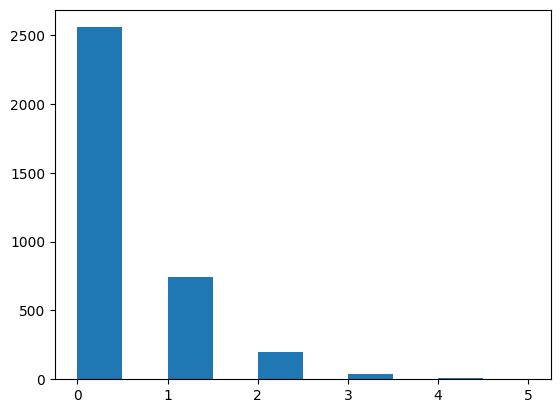

In [75]:
plt.hist(bc_counts.values())
plt.show()

For each read barcode that matched a reference barcode, find the reference gene sequence that is closest to the actual read gene sequence. The closest match should have the same barcode as the reference barcode that matched the read barcode.

In [84]:
gene_bc_matching = []
for read_bc, read_gene, ref_bc in tqdm(bc_matches):
    dists = bc_gene_pairs.apply(lambda row: Levenshtein.distance(row['ORF sequence'], read_gene), axis=1)
    best_match = bc_gene_pairs.iloc[dists.idxmin()]
    ref_gene = bc_gene_pairs[bc_gene_pairs['Barcode Sequence'] == ref_bc]['ORF sequence'].values[0]
    gene_bc_matching.append({'read_bc': read_bc, 'read_gene_seq': read_gene, 'ref_bc': ref_bc,
                             'ref_gene_seq': ref_gene, 'best_match_bc': best_match['Barcode Sequence'],
                             'best_match_gene_seq': best_match['ORF sequence'], 'distance': min(dists)})


100%|██████████| 1298/1298 [08:13<00:00,  2.63it/s]


In [93]:
gene_matching_df = pd.DataFrame(gene_bc_matching)
gene_matching_df['bc_match'] = gene_matching_df['ref_bc'] == gene_matching_df['best_match_bc']
print(f"{100 * sum(gene_matching_df['bc_match']) / len(gene_matching_df):0.2f}% of barcodes match the expected gene.")

90.06% of barcodes match the expected gene.


For reads that had genes that did not match the expected gene based on their barcode, align the read gene sequence to the gene sequence that is expected based on the read barcode.

In [94]:
aligner = PairwiseAligner(mode='global', match_score=2, mismatch_score=-1,
                          open_gap_score=-5, extend_gap_score=0)

In [127]:
def align_read_to_ref(row):
    if len(row['read_gene_seq']) > 0:
        alignments = aligner.align(row['ref_gene_seq'], row['read_gene_seq'])
        alignment = next(alignments)
        return (row.name, len(row['ref_gene_seq']), len(row['read_gene_seq']), encode_alignment(alignment[0], alignment[1]))
res = gene_matching_df.loc[~gene_matching_df['bc_match']].apply(align_read_to_ref, axis=1)
encoded = {f"{i[0]}, {i[1]}, {i[2]}": i[3] for i in res if i is not None}
pad_lengths(encoded)
alignments_df = pd.DataFrame.from_dict(encoded, orient='index')

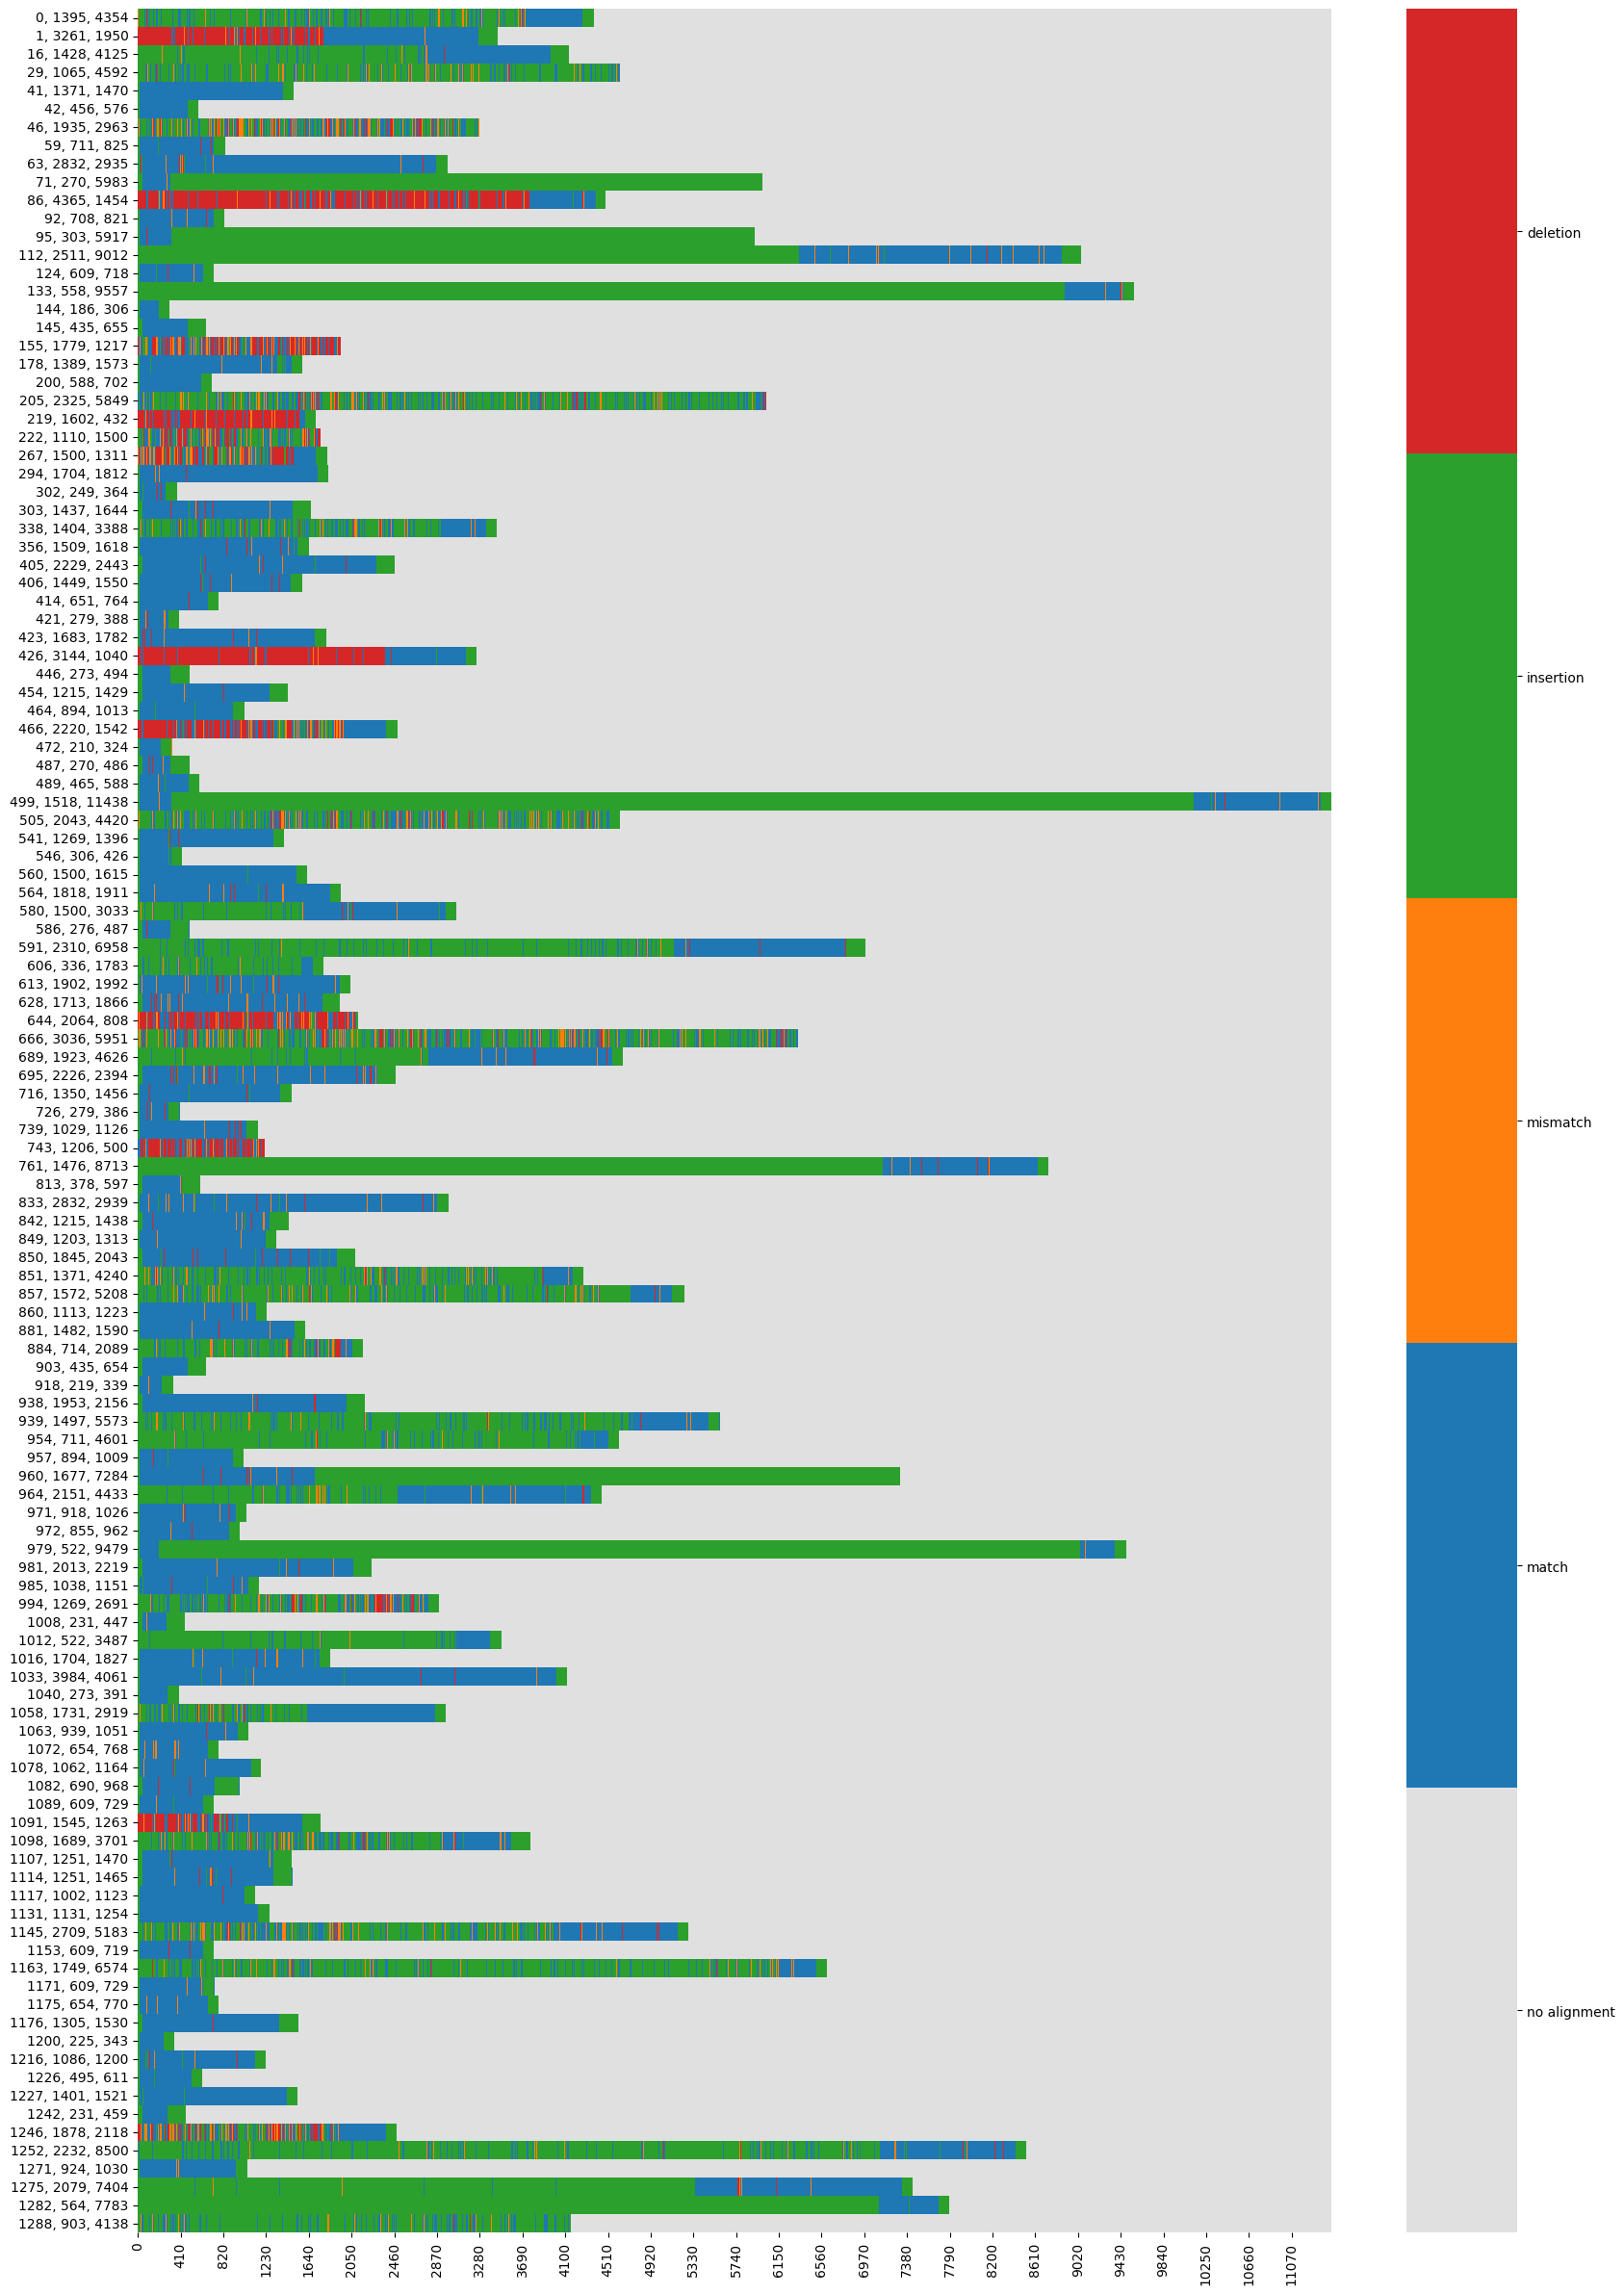

In [128]:
cmap = sns.color_palette(['#e0e0e0', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax = sns.heatmap(alignments_df, cmap=cmap, yticklabels=True)
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
colorbar.set_ticklabels(['no alignment', 'match', 'mismatch', 'insertion', 'deletion'])
plt.gcf().set_size_inches(20, 30)
plt.show()

In [130]:
gene_matching_df.iloc[1282]['read_gene_seq']

'TCGAACTCATCAACTCAATCTGATCATGTTGGCTCTAGCCATCCCGCCCCTAACTCCGCCCATCCCGCCCCTAACTCCGCCCAGTTCCGCCCATTCTCCGCCCCATGGCTGACTAATTTTTTTTATTTATGCAGAGGCCGAGGCCGCCTCGGCCTCTGAGCTATTCCAGAAGTAGTGAGGAGGCTTTTTCTGGAGGCCTAGGGACGTACCCAATTCGCCCTATAGTGAGTCGTATTACGCGCTCACTGGCCGTCGTTTTACAACGTCGTGACTGGGAAAACCCTGGCGTTACCCAACTTAATCGCCTTGCAGCACATCCCCCTTTCGCCAGCTGGCGTAATAGCGAAGAGGCCCGCACCGATCGCCCTTCCCAACAGTTGCGCAGCCTGAATGGCGAATGGGACGCGCCCTGTAGCGGCGCATTAAGCGCGGCGGGTGTGGTGGTTACGCGCAGCGTGACCGCTACACTTGCCAGCGCCCTAGCGCCCGCTCCTTTCGCTTTCTTCCCTTCCTCGCCACGTTCGCCGGCTTTCCCCGTCAAGCTCTAAATCGGGGGCTCCCTTTAGGGTTCCGATTTAGTGCTTTACGGCACCTCGACCCCAAAAAACTTGATTAGGGTGATGGTTCACGTAGTGGGCCATCGCCCTGATAGACGGTTTTTCGCCCTTTGACGTTGGAGTCCACGTTCTTTAATAACTAACTCTCGTTCCAAACTGGGACAACATGCTGCCTATCTCGGTCTATTCTTTTGATTTATAAGGGATTTTGCCGATTTCGGCCTATTGGTTAAAAAATGAGCTGATTTAACAAAAATTTAACGCGAATTTTAACAAAATATTAACGCTTACAATTTAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCGTATCCGTTTATTTTTCTAAATACATTCAAATATGTATCCGCTCATGAGACAATAACCCTGATAAATGCTTCAATAATATTGAAAAAGGAGAGTATGAGTATTCAACATT